In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [66]:
import h5py
import math
import re
import lm.input.Input_pb2 as inp
import lm.types.BoundaryConditions_pb2 as bc
import lm.io.ConcentrationsTimeSeries_pb2 as cts
import lm.io.SpeciesTimeSeries_pb2 as sts
from robertslab import ndarray
from robertslab.sfile import SFile
NA=6.02214179e23
testNames=[
           "one_source",
           "one_sink",
           "eight_sources_eight_sinks",
]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [67]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [68]:
%%bash
rm -rf tmp && mkdir tmp

### Create the test input files.

In [69]:
def create_one_source(testInputFilename):

    input=inp.Input()

    # Build the microenv model.
    gridShape=(1,200,200)
    input.microenv_model.initial_time = 0.0;
    input.microenv_model.synchronization_timestep = 0.01;
    input.microenv_model.grid_shape.extend(gridShape)
    input.microenv_model.grid_spacing = 4.0e-6
    input.microenv_model.species_index.append(0)
    input.microenv_model.diffusion_coefficients.append(1000e-12)
    input.microenv_model.boundaries.axis_specific_boundaries = True
    input.microenv_model.boundaries.x_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.x_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.z_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.z_minus = bc.BoundaryConditions().REFLECTING
    grid = np.zeros(gridShape)
    ndarray.serializeIntoPbufMessage(input.microenv_model.initial_concentrations.add(), grid)

    # Build the cells.
    input.microenv_model.number_cells = 1
    yi = [ 100]
    zi = [ 100]
    r1 = [  1]
    r2 = [  0]
    counts = np.zeros((input.microenv_model.number_cells,5), dtype=np.uint32)
    coords = np.zeros((input.microenv_model.number_cells,3))
    volume = np.zeros((input.microenv_model.number_cells,))
    for i in range(0,input.microenv_model.number_cells):
        counts[i,1] = r1[i]
        counts[i,2] = r2[i]
        coords[i,0] = 0.0
        coords[i,1] = yi[i]*4.0e-6
        coords[i,2] = zi[i]*4.0e-6
        volume[i] = 3.35e-14
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_initial_species_counts, counts)
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_coordinates, coords)
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_volume, volume)

    # Write the input to the file.
    file=SFile.fromFilename("%s.sfile"%(testInputFilename), "w")
    file.writeRecord("input", "protobuf:lm.input.Input", stringData=input.SerializeToString())
    file.close()        

In [70]:
def create_one_sink(testInputFilename):

    input=inp.Input()

    # Build the microenv model.
    gridShape=(1,200,200)
    input.microenv_model.initial_time = 0.0;
    input.microenv_model.synchronization_timestep = 0.001;
    input.microenv_model.grid_shape.extend(gridShape)
    input.microenv_model.grid_spacing = 4.0e-6
    input.microenv_model.species_index.append(0)
    input.microenv_model.diffusion_coefficients.append(1000e-12)
    input.microenv_model.boundaries.axis_specific_boundaries = True
    input.microenv_model.boundaries.x_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.x_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.z_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.z_minus = bc.BoundaryConditions().REFLECTING
    grid = np.zeros(gridShape)
    grid[:,:,:] = 5e-9
    ndarray.serializeIntoPbufMessage(input.microenv_model.initial_concentrations.add(), grid)

    # Build the cells.
    input.microenv_model.number_cells = 1
    yi = [ 100]
    zi = [ 100]
    r1 = [  0]
    r2 = [  1]
    counts = np.zeros((input.microenv_model.number_cells,5), dtype=np.uint32)
    coords = np.zeros((input.microenv_model.number_cells,3))
    volume = np.zeros((input.microenv_model.number_cells,))
    for i in range(0,input.microenv_model.number_cells):
        counts[i,1] = r1[i]
        counts[i,2] = r2[i]
        coords[i,0] = 0.0
        coords[i,1] = yi[i]*4.0e-6
        coords[i,2] = zi[i]*4.0e-6
        volume[i] = 3.35e-14
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_initial_species_counts, counts)
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_coordinates, coords)
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_volume, volume)

    # Write the input to the file.
    file=SFile.fromFilename("%s.sfile"%(testInputFilename), "w")
    file.writeRecord("input", "protobuf:lm.input.Input", stringData=input.SerializeToString())
    file.close()        

In [71]:
def create_eight_sources_eight_sinks(testInputFilename):

    input=inp.Input()

    # Build the microenv model.
    gridShape=(1,200,200)
    input.microenv_model.initial_time = 0.0;
    input.microenv_model.synchronization_timestep = 0.01;
    input.microenv_model.grid_shape.extend(gridShape)
    input.microenv_model.grid_spacing = 4.0e-6
    input.microenv_model.species_index.append(0)
    input.microenv_model.diffusion_coefficients.append(1000e-12)
    input.microenv_model.boundaries.axis_specific_boundaries = True
    input.microenv_model.boundaries.x_plus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.x_minus = bc.BoundaryConditions().REFLECTING
    input.microenv_model.boundaries.y_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.y_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.z_plus = bc.BoundaryConditions().LINEAR_GRADIENT
    input.microenv_model.boundaries.z_minus = bc.BoundaryConditions().LINEAR_GRADIENT
    grid = np.zeros(gridShape)
    ndarray.serializeIntoPbufMessage(input.microenv_model.initial_concentrations.add(), grid)

    # Build the cells.
    input.microenv_model.number_cells = 16
    yi = [ 70, 90,110,130,  70, 90,110,130,  70, 90,110,130,  70, 90,110,130]
    zi = [ 70, 70, 70, 70,  90, 90, 90, 90, 110,110,110,110, 130,130,130,130]
    r1 = [  1,  0,  1,  0,   0,  1,  0,  1,   1,  0,  1,  0,   0,  1,  0,  1]
    r2 = [  0,  1,  0,  1,   1,  0,  1,  0,   0,  1,  0,  1,   1,  0,  1,  0]
    counts = np.zeros((16,5), dtype=np.uint32)
    coords = np.zeros((16,3))
    volume = np.zeros((16,))
    for i in range(0,input.microenv_model.number_cells):
        counts[i,1] = r1[i]
        counts[i,2] = r2[i]
        coords[i,0] = 0.0
        coords[i,1] = yi[i]*4.0e-6
        coords[i,2] = zi[i]*4.0e-6
        volume[i] = 3.35e-14
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_initial_species_counts, counts)
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_coordinates, coords)
    ndarray.serializeIntoPbufMessage(input.microenv_model.cell_volume, volume)

    # Write the input to the file.
    file=SFile.fromFilename("%s.sfile"%(testInputFilename), "w")
    file.writeRecord("input", "protobuf:lm.input.Input", stringData=input.SerializeToString())
    file.close()        

In [72]:
createMethods = {"one_source": create_one_source,
                 "one_sink": create_one_sink,
                 "eight_sources_eight_sinks": create_eight_sources_eight_sinks}
for testName in testNames:
    testInputFilename="tmp/%s.input"%(testName)
    createMethods[testName](testInputFilename)
print "Finished."
pass

Finished.


In [73]:
%%bash -s "$test_names_bash_list"
sbmlFilename="microenv_source_sink.sbml"
for testName in $1; do
    lmInputFilename=tmp/${testName}.input.lm
    
    rm -f ${lmInputFilename} && lm_sbml_import ${lmInputFilename} ${sbmlFilename} > ${lmInputFilename}.import.log
    if [[ ${testName} == one* ]]; then
        lm_setp ${lmInputFilename} writeInterval=1e0 maxTime=1e2 > /dev/null
    elif [[ ${testName} == eight_sources_eight_sinks ]]; then
        lm_setp ${lmInputFilename} writeInterval=1e0 maxTime=1e2 > /dev/null
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
done;
echo "Finished."

Finished.


### Echo the commands for running the simulations

In [74]:
%%bash -s "$test_names_bash_list"
sbmlFilename="microenv_source_sink.sbml"
for testName in $1; do
    lmInputFilename=tmp/${testName}.input.lm
    sfileInputFilename=tmp/${testName}.input.sfile
    outputFilename=tmp/${testName}.sfile
    rm -f ${outputFilename} && rm -f ${outputFilename}.simulate.log
    
    if [[ ${testName} == *_avx ]]; then
        echo lmes -r 1-1 -me -f ${lmInputFilename},${sfileInputFilename} -ff sfile -fo ${outputFilename} -sl lm::avx::GillespieDSolverAVX
    else
        echo lmes -r 1-1 -me -f ${lmInputFilename},${sfileInputFilename} -ff sfile -fo ${outputFilename} -sl lm::cme::GillespieDSolver
    fi
done;
echo "Finished."

lmes -r 1-1 -me -f tmp/one_source.input.lm,tmp/one_source.input.sfile -ff sfile -fo tmp/one_source.sfile -sl lm::cme::GillespieDSolver
lmes -r 1-1 -me -f tmp/one_sink.input.lm,tmp/one_sink.input.sfile -ff sfile -fo tmp/one_sink.sfile -sl lm::cme::GillespieDSolver
lmes -r 1-1 -me -f tmp/eight_sources_eight_sinks.input.lm,tmp/eight_sources_eight_sinks.input.sfile -ff sfile -fo tmp/eight_sources_eight_sinks.sfile -sl lm::cme::GillespieDSolver
Finished.


### Execute the simulations.

In [75]:
%%bash -s "$test_names_bash_list"
sbmlFilename="microenv_source_sink.sbml"
for testName in $1; do
    lmInputFilename=tmp/${testName}.input.lm
    sfileInputFilename=tmp/${testName}.input.sfile
    outputFilename=tmp/${testName}.sfile
    rm -f ${outputFilename} && rm -f ${outputFilename}.simulate.log
    
    if [[ ${testName} == *_avx ]]; then
        lmes -r 1-1 -me -f ${lmInputFilename},${sfileInputFilename} -ff sfile -fo ${outputFilename} -sl lm::avx::GillespieDSolverAVX > ${outputFilename}.simulate.log
    else
        lmes -r 1-1 -me -f ${lmInputFilename},${sfileInputFilename} -ff sfile -fo ${outputFilename} -sl lm::cme::GillespieDSolver > ${outputFilename}.simulate.log
    fi
done;
echo "Finished."

Finished.


### Define the tests.

In [76]:
def loadMicroenvData(testOutputFilename):
    
    # Get the grid size and count the entries.
    numberTimes=0
    gridShape=None
    numberCells=0
    numberSpecies=None
    file=SFile.fromFilename(testOutputFilename, "r")
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.dataType == "protobuf:lm.io.ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            numberTimes += obj.times.shape[0]
            if gridShape is None: gridShape = tuple(obj.concentrations[0].shape)
        elif record.dataType == "protobuf:lm.io.SpeciesTimeSeries":
            obj=sts.SpeciesTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            cell = obj.trajectory_id
            numberCells=max(cell+1,numberCells)
            if numberSpecies is None: numberSpecies = obj.counts.shape[1]
        else:
            file.skipData(record.dataSize)
    file.close();    

    # Load the species counts for the cells.
    counts=np.zeros((numberTimes,numberCells,numberSpecies))
    file=SFile.fromFilename(testOutputFilename, "r")
    index={}
    for cell in range(0,numberCells):
        index[cell] = 0
    while True:
        record=file.readNextRecord()
        if record is None: break
        elif record.dataType == "protobuf:lm.io.SpeciesTimeSeries":
            obj=sts.SpeciesTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            cell = obj.trajectory_id
            recordCounts = ndarray.deserializePbufMessage(obj.counts)
            recordTimes = ndarray.deserializePbufMessage(obj.times)
            for i in range(0,recordCounts.shape[0]):
                #if recordTimes[i] != times[index[cell]]: print "Consistency error in cell %d: %e != %e"%(cell,recordTimes[i],times[index[cell]])
                counts[index[cell],cell,:] = recordCounts[i]
                index[cell] += 1
        else:
            file.skipData(record.dataSize)
    file.close();
    
    # Load the concentrations.
    times=np.zeros((numberTimes,), dtype=float)
    grids=np.zeros((numberTimes,)+gridShape, dtype=float)
    file=SFile.fromFilename(testOutputFilename, "r")
    index=0
    while True:
        record=file.readNextRecord()
        if record is None: break
        if record.dataType == "protobuf:lm.io.ConcentrationsTimeSeries":
            obj=cts.ConcentrationsTimeSeries()
            obj.ParseFromString(file.readData(record.dataSize))
            recordTimes = ndarray.deserializePbufMessage(obj.times)
            for j in range(0,recordTimes.shape[0]):
                times[index] = recordTimes[j]
                grids[index,:,:,:] = ndarray.deserializePbufMessage(obj.concentrations[j])
                index += 1
        else:
            file.skipData(record.dataSize)
    file.close();
    
    return (times,grids,counts)

In [77]:
def test_one_source(testOutputFilename):

    (times,grids,cells)=loadMicroenvData(testOutputFilename)
    
    if times.shape != (101,): raise Exception("incorrect number of times",times.shape)
    if grids.shape != (101,1,200,200): raise Exception("incorrect grids shape",grids.shape)
    if cells.shape != (101,1,5): raise Exception("incorrect cells shape",grids.shape)
        
    # Calculate the total number of molecules.
    lg=4e-6
    vg=(lg**3.0)*1000.0
    vc=3.35e-14
    moleculesGrid = grids*NA*vg
    moleculesCell = cells[:,0,0]
    moleculesFlux = (cells[:,0,0]-moleculesGrid[:,0,100,100]*vc/vg)/(1+vc/vg) # Have to account for the fact that new molecules are added to their grid element.
    moleculesPresentGrid = np.sum(moleculesGrid,(1,2,3))
    moleculesPresent = moleculesPresentGrid+moleculesFlux    
    moleculesProduced = cells[:,0,3]
    moleculesError = moleculesPresent-moleculesProduced

    
    # Plot the output.
    comparisonIndices=np.linspace(0,times.shape[0]-1,3, dtype=int)
    rows=2
    cols=comparisonIndices.shape[0]
    matplotlib.rcParams.update({'font.size': 10, "figure.figsize": (15,3*rows)})
    for i,index in enumerate(comparisonIndices):
        subplot(rows,cols,i+1)
        imshow(grids[index,0,:,:], interpolation='none', aspect=1, origin='lower', vmin=0, vmax=1e-8)
        cb=colorbar(label="c"); cb.ax.set_aspect(5)
        xlabel(r"x"); ylabel("y"); title("Sim t=%0.3f s"%times[index])
    subplot(2,3,4)
    plot(times, moleculesProduced)
    xlabel("Time"); ylabel("Molecules"); yscale('log'); title("Total Molecules Produced")
    subplot(2,3,5)
    plot(times, moleculesPresent)
    plot(times, moleculesFlux)
    plot(times, moleculesPresentGrid)
    xlabel("Time"); ylabel("Molecules"); yscale('log'); title("Molecules Present")
    subplot(2,3,6)
    plot(times, moleculesError)
    xlabel("Time"); ylabel("Molecules"); title("Error")

    # Check the output.
    value = np.max(abs(moleculesPresent-moleculesProduced))
    if value > 20: raise Exception("maximum error too large",value)
    value = mean(moleculesPresent-moleculesProduced)
    if not isclose(value,0.0,abs_tol=2): raise Exception("invalid mean error",value)

In [78]:
def test_one_sink(testOutputFilename):

    (times,grids,cells)=loadMicroenvData(testOutputFilename)
    
    if times.shape != (101,): raise Exception("incorrect number of times",times.shape)
    if grids.shape != (101,1,200,200): raise Exception("incorrect grids shape",grids.shape)
    if cells.shape != (101,1,5): raise Exception("incorrect cells shape",grids.shape)
        
    # Calculate the total number of molecules.
    lg=4e-6
    vg=(lg**3.0)*1000.0
    vc=3.35e-14
    moleculesGrid = grids*NA*vg
    moleculesCell = cells[:,0,0]
    moleculesFlux = (cells[:,0,0]-moleculesGrid[:,0,100,100]*vc/vg)/(1+vc/vg) # Have to account for the fact that new molecules are added to their grid element.
    moleculesPresentGrid = np.sum(moleculesGrid,(1,2,3))
    moleculesPresent = moleculesPresentGrid+moleculesFlux    
    moleculesRemaining = moleculesPresentGrid[0]-cells[:,0,4]
    moleculesError = moleculesPresent-moleculesRemaining
    
    # Plot the output.
    comparisonIndices=np.linspace(0,times.shape[0]-1,3, dtype=int)
    rows=2
    cols=comparisonIndices.shape[0]
    matplotlib.rcParams.update({'font.size': 10, "figure.figsize": (15,3*rows)})
    for i,index in enumerate(comparisonIndices):
        subplot(rows,cols,i+1)
        imshow(grids[index,0,:,:], interpolation='none', aspect=1, origin='lower', vmin=0, vmax=1e-8)
        cb=colorbar(label="c"); cb.ax.set_aspect(5)
        xlabel(r"x"); ylabel("y"); title("Sim t=%0.3f s"%times[index])
    subplot(2,3,4)
    plot(times, moleculesRemaining)
    xlabel("Time"); ylabel("Molecules"); yscale('log'); title("Total Molecules Remaining")
    subplot(2,3,5)
    plot(times, moleculesPresentGrid)
    xlabel("Time"); ylabel("Molecules"); yscale('log'); title("Molecules Present")
    subplot(2,3,6)
    plot(times, moleculesError)
    xlabel("Time"); ylabel("Molecules"); title("Error")
    
    # Check the output.
    value = np.max(abs(moleculesPresent-moleculesRemaining))
    if value > 10: raise Exception("maximum error too large",value)
    value = mean(moleculesPresent-moleculesRemaining)
    if not isclose(value,0.0,abs_tol=6.0): raise Exception("invalid mean error",value)

In [79]:
def test_eight_sources_eight_sinks(testOutputFilename):

    (times,grids,cells)=loadMicroenvData(testOutputFilename)
    
    if times.shape != (101,): raise Exception("incorrect number of times",times.shape)
    if grids.shape != (101,1,200,200): raise Exception("incorrect grids shape",grids.shape)
    if cells.shape != (101,16,5): raise Exception("incorrect cells shape",grids.shape)
        
    # Calculate the total number of molecules.
    lg=4e-6
    vg=(lg**3.0)*1000.0
    vc=3.35e-14
    moleculesGrid = grids*NA*vg
    
    # Plot the output.
    comparisonIndices=np.linspace(0,times.shape[0]-1,4, dtype=int)
    rows=2*comparisonIndices.shape[0]
    cols=comparisonIndices.shape[0]
    matplotlib.rcParams.update({'font.size': 10, "figure.figsize": (20,3*rows)})
    for i,index in enumerate(comparisonIndices):
        subplot(rows,cols,i+1)
        imshow(grids[index,0,:,:], interpolation='none', aspect=1, origin='lower', vmin=0, vmax=1e-8)
        cb=colorbar(label="c"); cb.ax.set_aspect(5)
        xlabel(r"x"); ylabel("y"); title("Sim t=%0.3f s"%times[index])
    for i in range(0,comparisonIndices.shape[0]):
        subplot(rows,cols,cols+i+1)
        plot(times, cells[:,i,0])
        xlabel("Time"); ylabel("Molecules"); title("Cell %d"%(i))

    # Check the output.
    cellValues=[526,0,501,0,0,555,0,523,515,0,526,0,0,515,0,480]
    for i in range(0,len(cellValues)):
        value = cells[-1,i,0]
        if not isclose(value,cellValues[i],0.1): raise Exception("invalid cell molecule count",i,value,cellValues[i])                
    gridValues=[380,220,401,177,220,454,258,403,404,258,451,220,177,399,220,372]
    yi = [ 70, 90,110,130,  70, 90,110,130,  70, 90,110,130,  70, 90,110,130]
    zi = [ 70, 70, 70, 70,  90, 90, 90, 90, 110,110,110,110, 130,130,130,130]
    for i in range(0,len(gridValues)):
        value = moleculesGrid[-1,0,yi[i],zi[i]]
        if not isclose(value,gridValues[i],0.05): raise Exception("invalid grid molecule count",i,value,gridValues[i])

### Run the tests.

[one_source]                                                 : passed.


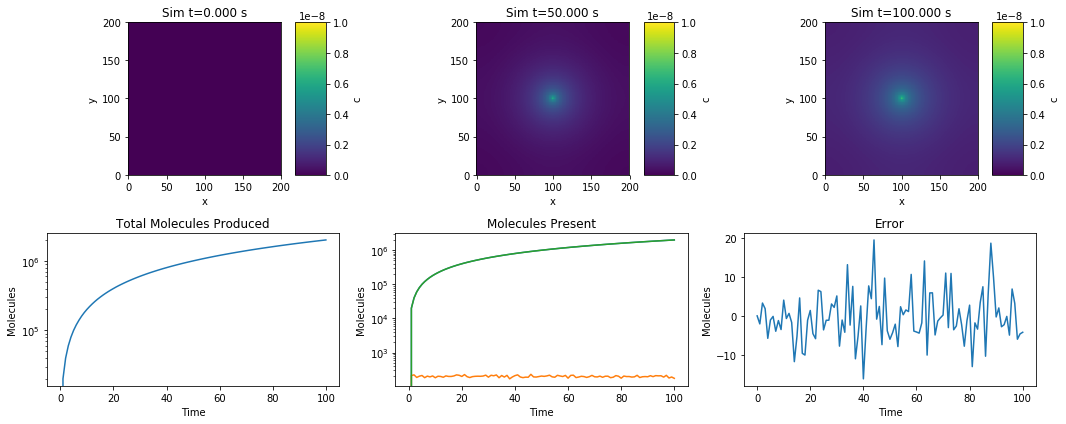

[one_sink]                                                   : passed.


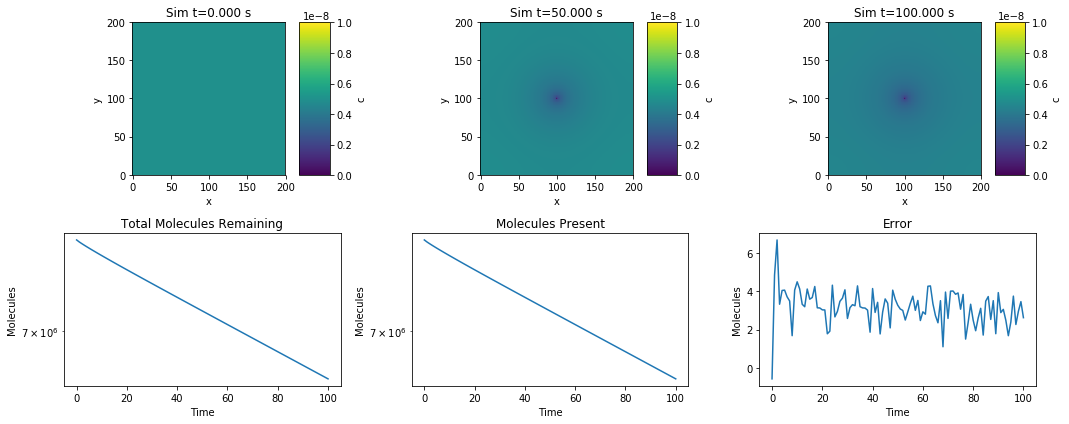

[eight_sources_eight_sinks]                                  : passed.


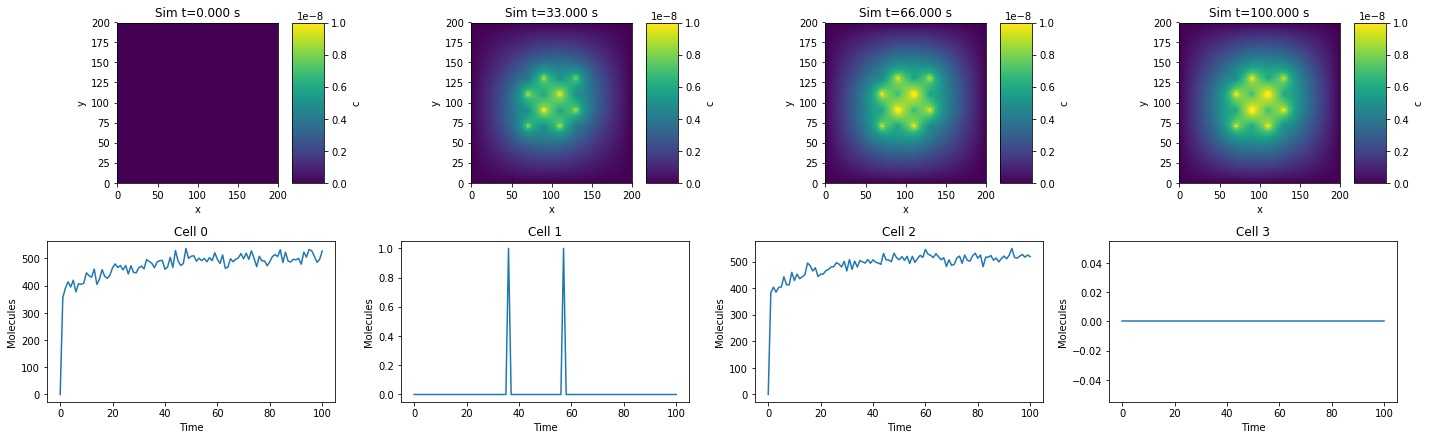

In [80]:
testMethods = {"one_source": test_one_source,
               "one_sink": test_one_sink,
               "eight_sources_eight_sinks": test_eight_sources_eight_sinks}
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.sfile"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.tight_layout()
    plt.show()
pass

In [81]:
%%bash
rm -rf tmp